<a href="https://colab.research.google.com/github/Andre6o6/mlcourse-2019/blob/master/Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://archive.org/download/nf_prize_dataset.tar/nf_prize_dataset.tar.gz

--2019-10-22 11:23:00--  https://archive.org/download/nf_prize_dataset.tar/nf_prize_dataset.tar.gz
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia800205.us.archive.org/7/items/nf_prize_dataset.tar/nf_prize_dataset.tar.gz [following]
--2019-10-22 11:23:01--  https://ia800205.us.archive.org/7/items/nf_prize_dataset.tar/nf_prize_dataset.tar.gz
Resolving ia800205.us.archive.org (ia800205.us.archive.org)... 207.241.230.25
Connecting to ia800205.us.archive.org (ia800205.us.archive.org)|207.241.230.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 697552028 (665M) [application/octet-stream]
Saving to: ‘nf_prize_dataset.tar.gz’

nf_prize_dataset.ta 100%[===================>] 665.24M  2.06MB/s    in 11m 8s  

2019-10-22 11:34:10 (1019 KB/s) - ‘nf_prize_dataset.tar.gz’ saved [697552028/697552028]



In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
#!cp nf_prize_dataset.tar.gz '/gdrive/My Drive/data/'
!cp '/gdrive/My Drive/data/nf_prize_dataset.tar.gz' .

In [0]:
!tar -xzf nf_prize_dataset.tar.gz
!tar -xf download/training_set.tar

Factorization machine from this paper: 
https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf

In [0]:
class FactorizationMachine:
    def __init__(self, n, k):
        self.w0 = 0
        self.w = np.zeros(n)
        self.v = np.zeros((n,k))

        self.lr = 1e-2

        self.x_batch = None

    def step_lr(self, alpha=0.1):
        self.lr = self.lr * alpha
    
    def forward(self, x):
        #Cache
        self.x_batch = x
        
        # Linear
        first = x @ self.w
        # Pairwise interactions
        second = 0.5 * np.sum(np.square(x @ self.v) - x.power(2) @ np.square(self.v), axis=-1)

        y = self.w0 + first + second
        return y

    def backward(self, dLdy):
        if self.x_batch is None:
            assert 0, 'Call forward first'

        # Bias grad, dy/dw0 = 1
        dLdw0 = np.mean(dLdy)
        
        # Np mean of sparse matrix gives matrix, so we cast to np array
        # and take 0'th element for correct shapes - (n,)
        dLdw = np.array(np.mean(self.x_batch.multiply(dLdy.reshape(-1,1)), axis=0))[0]

        
        # Could precompute this in forward pass
        v_dot_x = scipy.sparse.csr_matrix(self.x_batch @ self.v)
        
        # For every batch sample, calculate dL/dv = dL/dy * dy/dw 
        dLdv = [(x.reshape(-1,1).multiply(v_dot_x.getrow(i)) -    \
                 x.power(2).reshape(-1,1).multiply(self.v)) * dLdy[i] 
                for i,x in enumerate(self.x_batch)]
        
        # Mean gradients over all batch samples
        batch_size = self.x_batch.shape[0]
        dLdv = scipy.sum(dLdv, axis=0).toarray() / batch_size

        # Update weights
        self.w0 -= self.lr * dLdw0
        self.w -= self.lr * dLdw
        self.v -= self.lr * dLdv
        
        #Clear cache
        self.x_batch = None

In [0]:
class MSE:
    def __init__(self):
        self.err = None
    def forward(self, y_true, y_pred):
        self.err = y_true - y_pred
        return np.mean(np.square(self.err))
    def backward(self):
        if self.err is None:
            assert 0, 'Call forward first'
        return -2 * self.err

In [0]:
import os
import numpy as np

#print(len(os.listdir('training_set/')))

#with open('training_set/mv_0010218.txt') as f:
#  print(f.readlines())

In [0]:
transactions = np.zeros((100480507, 3), dtype=int)
i = 0

root = 'training_set/'
for filename in os.listdir(root):
    file = root + filename
    with open(file) as f:
        lines = f.readlines()
        movie_idx = int(lines[0].split(':')[0])
        for line in lines[1:]:
            user_idx, score, _ = line.split(',')
            user_idx, score = int(user_idx), int(score)
            transactions[i] = movie_idx, user_idx, score
            i+=1


In [0]:
import random
random.shuffle(transactions)

In [0]:
np.save('transactions.npy', transactions)
#!cp transactions.npy '/gdrive/My Drive/data/'

In [48]:
import gc
gc.collect()

326

In [0]:
transactions = np.load('transactions.npy')
transactions = transactions.astype(int)

In [0]:
transactions.shape

(100480507, 3)

In [0]:
n_movies = 17770    #1..17770

n_users = 480189
user_idxs = {x:i for i,x in enumerate(set(transactions[:, 1]))}

#scores = {1, 2, 3, 4, 5}

In [0]:
transactions = transactions[:1000000]

In [0]:
import scipy
from scipy.sparse import csc_matrix

def onehot(X):
    dtype = np.uint8
    rows = np.arange(X.size)
    cols = X
    data = np.ones(X.size, dtype=dtype)
    return csc_matrix((data, (rows,cols)))  #coo?

#Subtract 1 so that indexes are from 0 to 17770
oh_movies = onehot(transactions[:, 0] - 1)
#Map users to 0..480189 using user_idxs dict
oh_users = onehot(np.vectorize(user_idxs.get)(transactions[:, 1]))

y = transactions[:, 2]
X = scipy.sparse.hstack((oh_movies, oh_users)).tocsr()

In [0]:
n = X.shape[1]
k = 10
model = FactorizationMachine(n,k)

In [0]:
criterion = MSE()

In [0]:
test_ratio = 0.05
test_split = int(X.shape[0] * test_ratio)
X_train, X_test, y_train, y_test = X[test_split:], X[:test_split], y[test_split:], y[:test_split]

In [0]:
batch_size = 1000

iters = X_train.shape[0] // batch_size
if (X_train.shape[0] % batch_size > 0):
    iters += 1

def get_batch_numpy(i):
    return X_train[i*batch_size:(i+1)*batch_size], \
           y_train[i*batch_size:(i+1)*batch_size]

In [0]:
def r2_score(y, y_pred):
    y_avg = y.mean()
    ss_total = np.sum(np.square(y - y_avg))
    ss_err = np.sum(np.square(y - y_pred))
    return 1 - ss_err/ss_total

In [0]:
epochs = 1
for epoch in range(epochs):
    for i in range(iters):
        X_batch, y_batch = get_batch_numpy(i)

        y_pred = model.forward(X_batch)
        loss = criterion.forward(y_batch, y_pred)

        dLdy = criterion.backward()
        model.backward(dLdy)

        print("[{}]({}) l = {}".format(epoch, i, loss))
        print("\t r2 = {}".format(r2_score(y_batch, y_pred)))

In [0]:
y_pred = model.forward(X_test)
mse = criterion.forward(y_test, y_pred)
print("RMSE =", mse**0.5)
print("R2 =", r2_score(y_test, y_pred))

RMSE = 1.133851551679614
R2 = 0.05384853860236494


0.3340234605620474

In [0]:
class FactorizationMachineDense:
    def __init__(self, n, k):
        self.w0 = 0
        self.w = np.zeros(n)
        self.v = np.zeros((n,k))

        self.lr = 0.001

        #cache
        self.x_batch = None
        self.v_dot_x = None

    def forward(self, x):
        #Cache
        self.x_batch = x
        self.v_dot_x = x @ self.v
        
        first = x @ self.w
        second = 0.5 * np.sum(np.square(v_dot_x) - np.square(x) @ np.square(self.v), axis=-1)
        y = self.w0 + first + second
        return y

    def backward(self, dLdy):
        if self.x_batch is None:
            assert 0, 'Call forward first'

        dLdw0 = np.mean(dLdy)
        dLdw = np.mean(self.x_batch * dLdy, axis=0)

        b = self.x_batch.shape[0]
        n, k = self.v.shape
        dLdv = np.zeros((b,n,k))
        for i,x in enumerate(self.x_batch):
            dLdv[i] = (x[:, None] * (self.v_dot_x[i]) - self.v * np.square(x)[:, None]) * dLdy[i]
        dLdv = np.mean(dLdv, axis=0)


        self.w0 -= self.lr * dLdw0
        self.w -= self.lr * dLdw
        self.v -= self.lr * dLdv
        
        #Clear cache
        self.x_batch = None
        self.v_dot_x = None

In [0]:
import torch
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class FactorizationMachineTorch:
    def __init__(self, n, k):
        self.w0 = torch.tensor(0.1)
        self.w = 0.01*torch.randn(n)
        self.v = 0.01*torch.randn(n,k)

        self.lr = 0.01
        # Adam hypers
        self.beta1 = 0.9
        self.beta2 = 0.999
        # Adam moments
        self.v_dw0 = torch.zeros_like(self.w0.data)
        self.s_dw0 = torch.zeros_like(self.w0.data)
        self.v_dw = torch.zeros_like(self.w.data)
        self.s_dw = torch.zeros_like(self.w.data)
        self.v_dv = torch.zeros_like(self.v.data)
        self.s_dv = torch.zeros_like(self.v.data)
        # 
        self.t = 0
        self.eps = 1e-8

        #cache
        self.x_batch = None
        self.v_dot_x = None

    def to(self, device):
        self.w0 = self.w0.to(device)
        self.w = self.w.to(device)
        self.v = self.v.to(device)

        self.v_dw0 = self.v_dw0.to(device)
        self.s_dw0 = self.s_dw0.to(device)
        self.v_dw = self.v_dw.to(device)
        self.s_dw = self.s_dw.to(device)
        self.v_dv = self.v_dv.to(device)
        self.s_dv = self.s_dv.to(device)

    def forward(self, x):
        #Cache
        self.x_batch = x
        self.v_dot_x = torch.mm(x, self.v)
        
        return self.w0   \
               + torch.matmul(x, self.w)   \
               + 0.5 * torch.sum(self.v_dot_x.pow(2) - torch.mm(x.pow(2), self.v.pow(2)), dim=-1)
         
    def backward(self, dLdy):
        if self.x_batch is None:
            assert 0, 'Call forward first'

        dLdw0 = torch.mean(dLdy)
        dLdw = torch.mean(self.x_batch * dLdy.view(-1,1), dim=0)

        b = self.x_batch.shape[0]
        n, k = self.v.shape
        #dLdv = torch.zeros(n,k, device=device)
        #for xi, v_dot_xi, dLdyi in zip(self.x_batch, self.v_dot_x, dLdy):
        #    dLdv.add_(dLdyi, xi.view(-1,1) * v_dot_xi - self.v * xi.pow(2).view(-1,1))
        #dLdv.div_(b)
        dLdv = torch.einsum('bn, bk -> bnk', (self.x_batch, self.v_dot_x))
        dLdv.sub_(torch.einsum('bn, nk -> bnk', (self.x_batch.pow(2), self.v)))
        dLdv.mul_(dLdy.view(-1,1,1))
        dLdv = dLdv.mean(dim=0)
        

        #ADAM: estimate moments
        self.v_dw0.mul_(self.beta1).add_(1 - self.beta1, dLdw0)
        self.s_dw0.mul_(self.beta2).addcmul_(1 - self.beta2, dLdw0, dLdw0)
        self.v_dw.mul_(self.beta1).add_(1 - self.beta1, dLdw)
        self.s_dw.mul_(self.beta2).addcmul_(1 - self.beta2, dLdw, dLdw)
        self.v_dv.mul_(self.beta1).add_(1 - self.beta1, dLdv)
        self.s_dv.mul_(self.beta2).addcmul_(1 - self.beta2, dLdv, dLdv)
        #ADAM: correct moments
        self.t+=1
        bias_correction1 = 1 - self.beta1**self.t
        bias_correction2 = 1 - self.beta2**self.t

        denom_w0 = (self.s_dw0.sqrt() / math.sqrt(bias_correction2)).add_(self.eps)        
        denom_w = (self.s_dw.sqrt() / math.sqrt(bias_correction2)).add_(self.eps)      
        denom_v = (self.s_dv.sqrt() / math.sqrt(bias_correction2)).add_(self.eps) 

        #ADAM: Update weights
        step_size = self.lr / bias_correction1
        self.w0.data.addcdiv_(-step_size, self.v_dw0, denom_w0)
        self.w.data.addcdiv_(-step_size, self.v_dw, denom_w)
        self.v.data.addcdiv_(-step_size, self.v_dv, denom_v)
        
        #Clear cache
        self.x_batch = None
        self.v_dot_x = None

In [0]:
class MSE_torch:
    def __init__(self):
        self.err = None
    def forward(self, y_true, y_pred):
        self.err = y_true - y_pred
        return torch.mean((self.err).pow(2))
    def backward(self):
        if self.err is None:
            assert 0, 'Call forward first'
        return -2 * self.err

In [0]:
def r2_score(y, y_pred):
    y_avg = y.mean()
    ss_total = np.sum(np.square(y - y_avg))
    ss_err = np.sum(np.square(y - y_pred))
    return 1 - ss_err/ss_total

In [0]:
n = X.shape[1]
k = 10
model = FactorizationMachineTorch(n,k)
model.to(device)

criterion = MSE_torch()

In [0]:
batch_size = 100

iters = X_train.shape[0] // batch_size
if (X_train.shape[0] % batch_size > 0):
    iters += 1

def get_batch_torch(i):
    return torch.tensor(X_train[i*batch_size:(i+1)*batch_size].toarray(), dtype=torch.float32), \
           torch.tensor(y_train[i*batch_size:(i+1)*batch_size], dtype=torch.float32)

In [0]:
import time
history = []
history_r2 = []
epochs = 1
for epoch in range(epochs):
    for i in range(iters):
        X_batch, y_batch = get_batch_torch(i)

        y_pred = model.forward(X_batch.to(device))
        loss = criterion.forward(y_batch.to(device), y_pred)

        dLdy = criterion.backward()
        model.backward(dLdy)

        if (i + 1) % 10 == 0:
            print("[{}]({}) l = {}".format(epoch, i, loss))
            r2 = r2_score(y_batch.cpu().numpy(), y_pred.cpu().numpy())
            history_r2.append(loss)
            print("\t r2 = {}".format(r2))

        history.append(loss)

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'MSE')

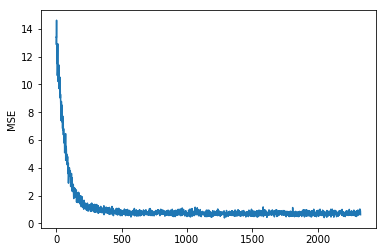

In [73]:
%pylab inline
plt.plot(history)
plt.ylabel("MSE")

In [81]:
import tqdm

batch_size = 1000
iters = X_test.shape[0] // batch_size
if (X_test.shape[0] % batch_size > 0):
    iters += 1

def get_test(i):
    return torch.tensor(X_test[i*batch_size:(i+1)*batch_size].toarray(), dtype=torch.float32)

y_pred = np.zeros(y_test.shape)

for i in tqdm.tqdm(range(iters)):
    X_batch = get_test(i)
    y_pred[i*batch_size:(i+1)*batch_size] = model.forward(X_batch.to(device)).cpu().numpy()

print()
print("RMSE =", MSE().forward(y_test, y_pred))
print("R2 =", r2_score(y_test, y_pred))

100%|██████████| 50/50 [01:04<00:00,  1.29s/it]

RMSE = 0.39525254984356556
R2 = 0.6567962289234461
